This tutorial notebook shows how to fit a noise agnostic model to massively parallel assay (Sort-Seq) data. 

In [10]:
# necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import mavenn
from mavenn.src.utils import get_example_dataset
import logomaker
import seaborn as sns

Load data using mavenn's helper method. 

In [2]:
sequences, bin_counts = get_example_dataset(name='Sort-Seq')

In [3]:
# sequences is an array of 39-nt sequences
sequences[0:5]

array(['CGCTTTATAGTTTTTGCTTCCGGCTCGTATGTTGTGTGG',
       'GGCTTGACACATTATCCGTTCCGCTCGTATGTTGTCTGG',
       'GTCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG',
       'GGCTTTACAATTTATGCTTCTGGCTCGTATGTTGTTTGG',
       'GGCTTTACACCTTATGCTTCTTGCTCGTATATTGTGTGG'], dtype='<U39')

In [4]:
# bin_counts = counts in bins (1-9) that sequences got sorted into
# bin-0 represents counts of the library
bin_counts[0:5]

array([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## Fit NA model to data

In [5]:
# load mavenn's NA model
NAR = mavenn.Model(regression_type='NA',
                   X=sequences,
                   y=bin_counts,
                   learning_rate=0.0025,
                   model_type='additive',
                   alphabet_dict='dna',
                   ohe_single_batch_size=50000)

NAR.fit(epochs=200, use_early_stopping=True, early_stopping_patience=20, verbose=1)

One-hot encoding...
Train on 40414 samples, validate on 10104 samples
Epoch 1/200
40414/40414 [==============================] - 1s 35us/step - loss: 1.0911 - categorical_accuracy: 0.1314 - val_loss: 1.0896 - val_categorical_accuracy: 0.1590
Epoch 2/200
40414/40414 [==============================] - 1s 28us/step - loss: 1.0892 - categorical_accuracy: 0.1709 - val_loss: 1.0891 - val_categorical_accuracy: 0.1618
Epoch 3/200
40414/40414 [==============================] - 1s 28us/step - loss: 1.0889 - categorical_accuracy: 0.1770 - val_loss: 1.0889 - val_categorical_accuracy: 0.1743
Epoch 4/200
40414/40414 [==============================] - 1s 28us/step - loss: 1.0888 - categorical_accuracy: 0.1781 - val_loss: 1.0887 - val_categorical_accuracy: 0.1698
Epoch 5/200
40414/40414 [==============================] - 1s 28us/step - loss: 1.0887 - categorical_accuracy: 0.1808 - val_loss: 1.0886 - val_categorical_accuracy: 0.1711
Epoch 6/200
40414/40414 [==============================] - 1s 28us/ste

40414/40414 [==============================] - 1s 30us/step - loss: 1.0882 - categorical_accuracy: 0.1848 - val_loss: 1.0881 - val_categorical_accuracy: 0.1818
Epoch 49/200
40414/40414 [==============================] - 1s 31us/step - loss: 1.0882 - categorical_accuracy: 0.1850 - val_loss: 1.0881 - val_categorical_accuracy: 0.1824
Epoch 50/200
40414/40414 [==============================] - 1s 29us/step - loss: 1.0881 - categorical_accuracy: 0.1833 - val_loss: 1.0881 - val_categorical_accuracy: 0.1855
Epoch 51/200
40414/40414 [==============================] - 1s 28us/step - loss: 1.0881 - categorical_accuracy: 0.1830 - val_loss: 1.0882 - val_categorical_accuracy: 0.1820
Epoch 52/200
40414/40414 [==============================] - 1s 29us/step - loss: 1.0882 - categorical_accuracy: 0.1854 - val_loss: 1.0881 - val_categorical_accuracy: 0.1860
Epoch 53/200
40414/40414 [==============================] - 1s 28us/step - loss: 1.0881 - categorical_accuracy: 0.1835 - val_loss: 1.0882 - val_cate

## evaluate loss

In [8]:
loss_history =  NAR.model.return_loss()

# evaluate the inferred noise model for a given input range
phi_range = np.linspace(-20, 20,1000)
noise_model = NAR.na_noisemodel(sequences,
                                input_range=phi_range)


## Plot results

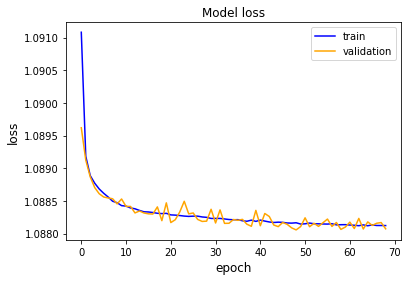

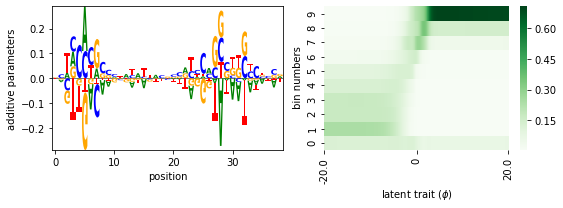

In [9]:
plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# make logo to visualize additive parameters
ax[0].set_ylabel('additive parameters')
ax[0].set_xlabel('position')

theta_df = pd.DataFrame(NAR.nn_model().layers[1].get_weights()[0].reshape(39, 4),columns=['A', 'C', 'G', 'T'])

additive_logo = logomaker.Logo(theta_df/np.sqrt(np.sum(theta_df.values.ravel()**2)),
                               center_values=True,
                               ax=ax[0])

# view the inferred noise model as a heatmap
noise_model_heatmap = sns.heatmap(noise_model.T, cmap='Greens', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_xticks(([0,int(len(phi_range)/2), len(phi_range)-2]), minor=False)
ax[1].set_xticklabels(([str(phi_range[0]), 0, str(phi_range[len(phi_range)-1])]), minor=False)
ax[1].set_ylabel(' bin numbers')
ax[1].set_xlabel('latent trait ($\phi$)')

plt.tight_layout()
plt.show()